Data Description:
*     The dataset used in the project is the Histopathologic Cancer Detection dataset rom Kaggle, the link of the dataset is: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)
* Each input is a small pathology image that to be classified to a binary class. The positive label indicates that the center 32*32 px region of a patch contains at least one pixel of tumor tissue. 
* The train_labels.csv file provides the class of each associated image in train folder.
* @misc{histopathologic-cancer-detection,
    author = {Will Cukierski},
    title = {Histopathologic Cancer Detection},
    publisher = {Kaggle},
    year = {2018},
    url = {https://kaggle.com/competitions/histopathologic-cancer-detection}
}    

In [12]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  Dropout,Flatten, Conv2D,MaxPooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [13]:
# read Label from kaggle
Label = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [14]:
# take a look at the data
print(f'The shape of the label file is: {Label.shape}')
print('The first 5 rows are:')
print(Label.head())

The shape of the label file is: (220025, 2)
The first 5 rows are:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


* The dataset has 220025 rows and 2 columns. The column id indicates the file name of the image and the label indicates the class of that image.

In [15]:
Label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


* The data type in the label column is integer, need to change to object.

In [16]:
# change the data type of the label column from int to object
Label['label']=Label['label'].astype('str')

In [17]:
Label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [18]:
# Add the formate of each image to its file name for easier image loading
Label['id'] = Label['id'].apply(lambda x : x+ '.tif')

In [19]:
Label.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [20]:
Label.label.value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [21]:
Label.label.value_counts()[0]/(Label.label.value_counts()[0]+Label.label.value_counts()[1])

0.5949687535507329

* There are 59% of class 0 in the dataset and 41% of class 1 in the dataset.

In [22]:
# helper function to load the image
def load_image(curr_dir,img_id):
    """function to read the image from its path 
    input: img_id is the id of the image file
    """
    path = curr_dir + img_id 
    im = cv2.imread(path)
    return im
    

The size of the image is : (96, 96, 3)
The maximum value of the image is : 255


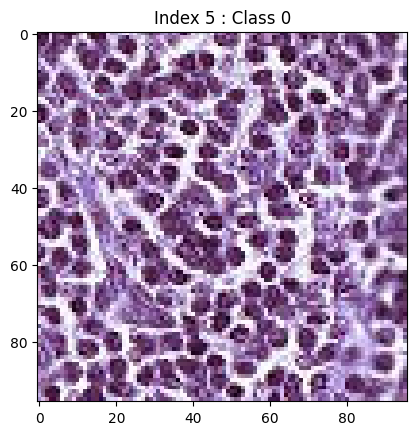

In [23]:
# example image
curr_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
i = 5 # index of Label DataFrame
s=load_image(curr_dir,Label.iloc[i]['id'])
plt.imshow(s)
cl = Label.iloc[i]['label']
plt.title(f'Index {i} : Class {cl}')

# take a look at the image
print(f'The size of the image is : {s.shape}')
print(f'The maximum value of the image is : {s.max()}')

In [24]:
# split training dataset to train and validation sets (75%)
train, validation = train_test_split(Label,test_size=0.25,random_state=401,stratify=Label.label)
print(train.shape,validation.shape)

(165018, 2) (55007, 2)


In [25]:
# take a look at the train dataset
train.head(5)

,id,label
103606,dc269106252e1b18a7846b3cf2eccf7629124265.tif,1
151517,ea5f6f2774e9ef903e4a805f298781b2e568a1bc.tif,0
129934,8a91b11b9149b2529325a6afb7f871c01577a700.tif,0
54105,dc9cddf3400139631aa0d25df349f0a854592d07.tif,0
175007,742ca8bcc89450da71ae7c34a83d4042fa15b486.tif,1


In [26]:
# resest the index of train and validation dataset
train.reset_index(inplace=True)
validation.reset_index(inplace=True)

In [27]:
# create a image generator 
image_gen = ImageDataGenerator(rotation_range=45, 
                                    rescale = 1/255,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    shear_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                    fill_mode='nearest')

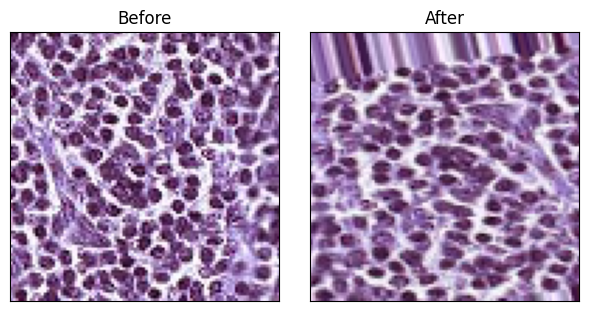

In [28]:
# take a look at random transformed image compare with the original image
fig,axs = plt.subplots(1,2,figsize=(6,3),layout='constrained',sharex=True,sharey=True)
axs[0].set(title='Before',aspect=1,xticks=[],yticks=[])
axs[0].imshow(s)
axs[1].set(title='After',aspect=1,xticks=[],yticks=[])
axs[1].imshow(image_gen.random_transform(np.array(s)));

In [29]:
# generate image for training dataset
curr_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
input_size=(96,96)
batch_size = 16
train_gen = image_gen.flow_from_dataframe(train,directory=curr_dir,x_col='id',y_col='label',
                                          target_size=input_size,batch_size=batch_size,seed=401,
                                          class_mode='binary',shuffle=True)

Found 165018 validated image filenames belonging to 2 classes.


In [30]:
# generate image for validaiton dataset
val_gen = image_gen.flow_from_dataframe(validation,directory=curr_dir,x_col='id',y_col='label',
                                          target_size=input_size,batch_size=batch_size,seed=401,
                                        class_mode='binary',shuffle=False)

Found 55007 validated image filenames belonging to 2 classes.


In [31]:
# create a CNN model
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=(96,96,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(96,96,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Dropout(0.4))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',
             metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [33]:
train_steps = len(train)/batch_size
val_steps = len(validation)/batch_size
print(train_steps,val_steps)

10313.625 3437.9375


In [34]:
# save model
model_save = ModelCheckpoint('./Model_v1.h5',
                            save_best_only = True,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',verbose=1)


In [35]:
# set an early stop to provent overfitting
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=4,mode='min',verbose=1,
                          restore_best_weights= True)

In [36]:
# reduce the learning rate if needed
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_delta=0.002,
                             mode='min',verbose=1)

In [37]:
epochs = 10
results = model.fit(train_gen,steps_per_epoch=train_steps,epochs=epochs,
                    validation_data=val_gen,validation_steps=val_steps,
                   callbacks=[model_save,early_stop,reduce_lr])

Epoch 1/10
10314/10313 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.6261
Epoch 1: val_loss improved from inf to 0.72498, saving model to ./Model_v1.h5
10313/10313 [==============================] - 1719s 166ms/step - loss: 0.6480 - accuracy: 0.6261 - val_loss: 0.7250 - val_accuracy: 0.5950 - lr: 0.0010
Epoch 2/10
10314/10313 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.5949
Epoch 2: val_loss improved from 0.72498 to 0.69984, saving model to ./Model_v1.h5
10313/10313 [==============================] - 900s 87ms/step - loss: 0.6770 - accuracy: 0.5949 - val_loss: 0.6998 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 3/10
10314/10313 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.5949
Epoch 3: val_loss did not improve from 0.69984
10313/10313 [==============================] - 918s 89ms/step - loss: 0.6782 - accuracy: 0.5949 - val_loss: 1.1429 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 4/10
10314/10313 [==============

In [38]:
history = pd.DataFrame(model.history.history)

In [39]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(8,8))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history['loss'], color='blue', label='train')
    plt.plot(history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history['accuracy'], color='blue', label='train')
    plt.plot(history['val_accuracy'], color='orange', label='test')
    plt.legend()

In [1]:
summarize_diagnostics(history)

NameError: name 'summarize_diagnostics' is not defined

In [41]:
Image.open(test_dir+ss.iloc[1]['id']+'.tif')

NameError: name 'test_dir' is not defined

In [ ]:
ss=pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

preds=[]

for image_id in ss['id']:
    image = Image.open('/kaggle/input/histopathologic-cancer-detection/test/'+ image_id+'.tif')
#     image = image.resize(96,96,3)
    image = np.expand_dims(image,axis=0)
    preds.append(model.predict(image))

ss['label'] = preds

ss.to_csv('results.csv')

In [ ]:
ss